<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/o_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network tiny example

Let's create a CNN to recognize X or O shapes in a 9 x 9 pixel image and visualize convolutional filters and filtered images.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.losses import mean_squared_error
from keras.utils import img_to_array
from keras.optimizers import SGD

In [2]:
# some constants
image_size = 18                 # size of sub images in pixel (squre shaped)
train_start = 0
train_rows = 10
train_cols = test_cols = 10
test_rows = 4
train_num = train_rows * train_cols
test_start = 12
test_num = test_rows * test_cols
size = 118                      # original size of a marker
border = 5                      # cut border around marker
labels = ["circle", "cross"]

In [3]:
!wget -q -O o_x.png https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/o_x.png?raw=true

In [4]:
# load all train and test as one image
img = Image.open('o_x.png').convert('L')

In [5]:
# training and test data
X_train = np.zeros((train_num, image_size, image_size), dtype='float32')
y_train = np.zeros(train_num, dtype='float32')
y_train[train_num // 2:] = 1
X_test = np.zeros((test_num, image_size ,image_size), dtype='float32')
y_test = np.zeros(test_num, dtype='float32')
y_test[test_num // 2:] = 1

In [7]:
# create train images
k = 0
for i in range(train_start, train_start + train_rows):     # rows
    pixel_top = i * size + border
    pixel_bot = (i + 1) * size - border
    for j in range(10): # columns
        pixel_left = j * size + border
        pixel_righ = (j + 1) * size - border
        box = (pixel_left, pixel_top, pixel_righ, pixel_bot)
        sub_img = img_to_array(img.crop(box).resize((image_size, image_size)))[:,:,0]
        X_train[k] = sub_img / 256.
        k += 1

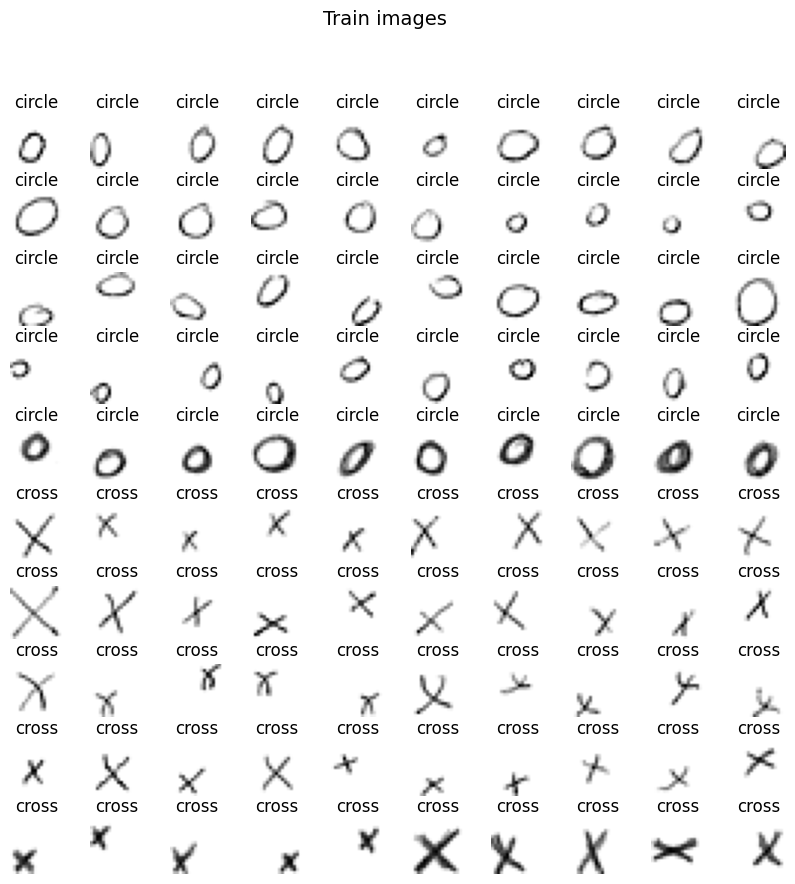

In [63]:
# show train images
fig, ax = plt.subplots(train_rows, train_cols, figsize=(train_cols, train_rows))
fig.suptitle('Train images', fontsize=14)
ax = ax.ravel()
for i in range(100):
    ax[i].imshow(X_train[i], cmap='gray')
    ax[i].set_title(labels[int(y_train[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [9]:
# create test images
k = 0
for i in range(test_start, test_start + test_rows):    # rows
    pixel_top = i * size + border
    pixel_bot = (i + 1) * size - border
    for j in range(10): # columns
        pixel_left = j * size + border
        pixel_righ = (j + 1) * size - border
        box = (pixel_left, pixel_top, pixel_righ, pixel_bot)
        sub_img = img_to_array(img.crop(box).resize((image_size, image_size)))[:,:,0]
        X_test[k] = sub_img / 256.
        k += 1

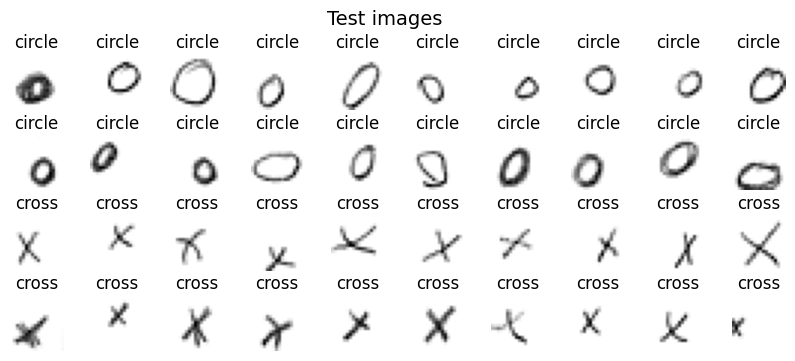

In [64]:
# show test images
fig, ax = plt.subplots(4,10, figsize=(10, 4))
fig.suptitle('Test images', fontsize=14)
ax = ax.ravel()
for i in range(40):
    ax[i].imshow(X_test[i], cmap='gray')
    ax[i].set_title(labels[int(y_test[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [68]:
# building the model
model = Sequential()
model.add(Conv2D(8, (3, 3), padding='same', input_shape=(image_size, image_size, 1), activation='relu', kernel_initializer='variance_scaling'))
#model.add(Conv2D(8, (3, 3), padding='same', activation='relu', kernel_initializer='variance_scaling'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Dropout(0.2))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='variance_scaling'))
#model.add(Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer='variance_scaling'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax', kernel_initializer='variance_scaling'))
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss=mean_squared_error, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 18, 18, 8)         80        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 16)          1168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [69]:
%%time
epochs = 10
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/10
4/4 [==============================] - 1s 90ms/step - loss: 0.2633 - accuracy: 0.5400 - val_loss: 0.2506 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 0s 20ms/step - loss: 0.2637 - accuracy: 0.4800 - val_loss: 0.2502 - val_accuracy: 0.4250
Epoch 3/10
4/4 [==============================] - 0s 19ms/step - loss: 0.2657 - accuracy: 0.4100 - val_loss: 0.2501 - val_accuracy: 0.5250
Epoch 4/10
4/4 [==============================] - 0s 22ms/step - loss: 0.2630 - accuracy: 0.5300 - val_loss: 0.2501 - val_accuracy: 0.4500
Epoch 5/10
4/4 [==============================] - 0s 17ms/step - loss: 0.2638 - accuracy: 0.5200 - val_loss: 0.2501 - val_accuracy: 0.5000
Epoch 6/10
4/4 [==============================] - 0s 18ms/step - loss: 0.2616 - accuracy: 0.5000 - val_loss: 0.2504 - val_accuracy: 0.4250
Epoch 7/10
4/4 [==============================] - 0s 17ms/step - loss: 0.2650 - accuracy: 0.5400 - val_loss: 0.2505 - val_accuracy: 0.5000
Epoch 8/10
4/4 [===========

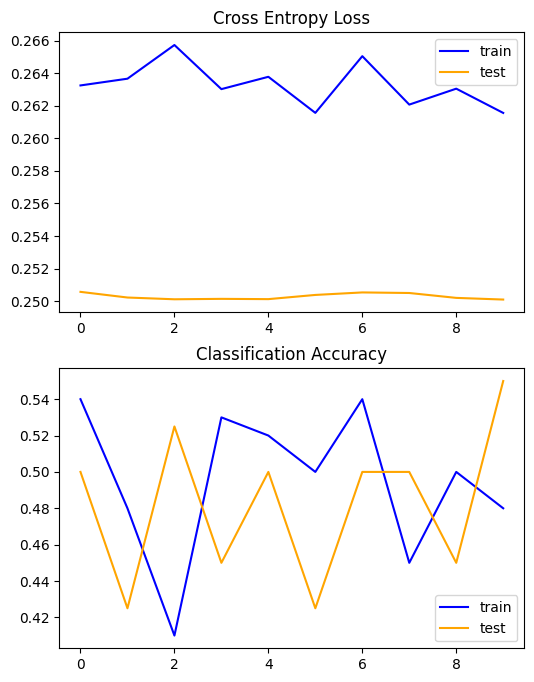

In [70]:
# plot diagnostic learning curves and optionaly save to file
def summarize_diagnostics(history, filename=None):
    # if file name given curves are saved to file and not displayed on screen
    fig, ax = plt.subplots(2, 1, figsize=(6, 8))
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue', label='train')
    ax[0].plot(history.history['val_loss'], color='orange', label='test')
    ax[0].legend()
    # plot accuracy
    #plt.subplot(212)
    ax[1].set_title('Classification Accuracy')
    ax[1].plot(history.history['accuracy'], color='blue', label='train')
    ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
    ax[1].legend(loc=4)
    plt.subplots_adjust(wspace=0.5)
    if filename:
        # save plot to file
        pyplot.savefig(filename + '_plot.png')
        pyplot.close()

summarize_diagnostics(history)

In [73]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
pred_test_classes = np.argmax(y_pred_test, axis=1)
pred_train_classes = np.argmax(y_pred_train, axis=1)

4/4 [==============================] - 0s 4ms/step


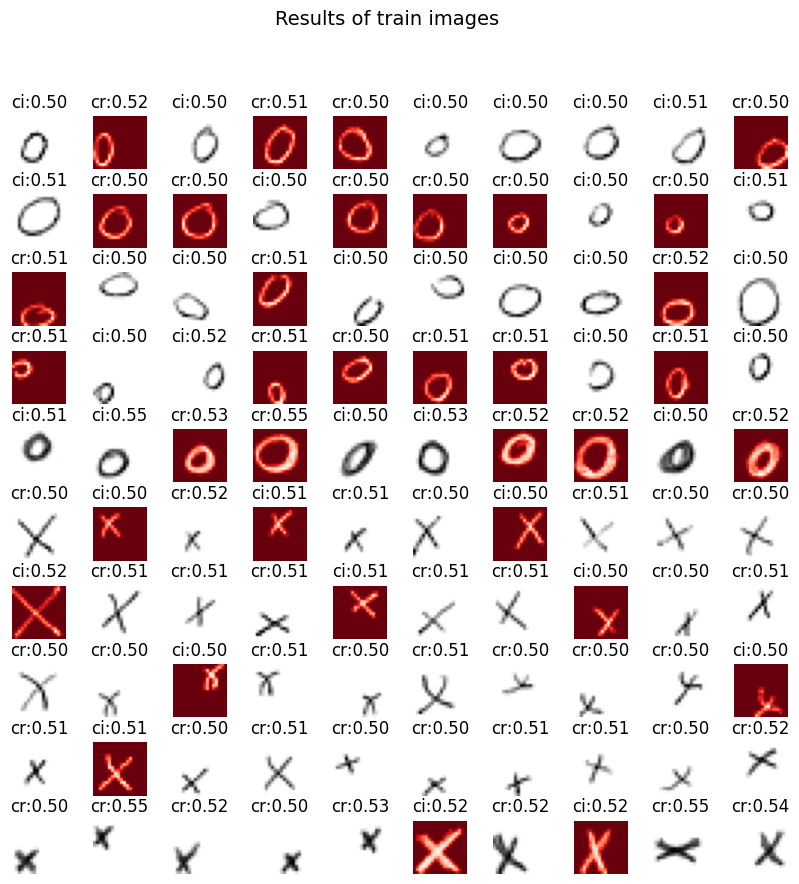

In [78]:
# show train images
fig, ax = plt.subplots(train_rows, train_cols, figsize=(train_cols, train_rows))
fig.suptitle('Results of train images', fontsize=14)
ax = ax.ravel()
for i in range(train_num):
    cls = pred_train_classes[i]     # 0/1
    val = y_pred_train[i, cls]
    cmap = 'gray' if cls == y_train[i] else 'Reds'
    ax[i].imshow(X_train[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.2f}")
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

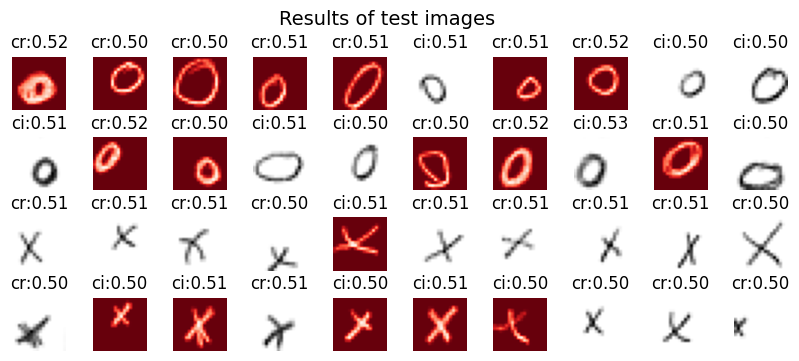

In [79]:
# show test images
fig, ax = plt.subplots(test_rows, test_cols, figsize=(test_cols, test_rows))
fig.suptitle('Results of test images', fontsize=14)
ax = ax.ravel()
for i in range(test_num):
    cls = pred_test_classes[i]     # 0/1
    val = y_pred_test[i, cls]
    cmap = 'gray' if cls == y_test[i] else 'Reds'
    ax[i].imshow(X_test[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(cls)][:2]}:{val:.2f}")
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [12]:
from sklearn import svm
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [13]:
# preparing data
XX_train = np.zeros((train_num, image_size * image_size), dtype='float32')
XX_test = np.zeros((test_num, image_size * image_size), dtype='float32')
for i in range(X_train.shape[0]):
    XX_train[i] = X_train[i].reshape(image_size * image_size)
for i in range(X_test.shape[0]):
    XX_test[i] = X_test[i].reshape(image_size * image_size)

In [46]:
# hyper parameter estimation
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = [{'C': C_range, 'gamma': gamma_range, 'kernel': ['linear', 'poly', 'rbf']}]
base_estimator = svm.SVC()
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=3,
                         factor=2,
                         max_resources=30).fit(XX_train, y_train)
sh.best_params_

{'C': 10000000.0, 'gamma': 1e-08, 'kernel': 'rbf'}

{'C': 10000000.0, 'gamma': 1e-08, 'kernel': 'rbf'} - ~78%

In [47]:
sh.best_estimator_

SVC(C=10000000.0, gamma=1e-08)

In [53]:
clf = sh.best_estimator_
clf.fit(XX_train, y_train)
y_test_pred = clf.predict(XX_test)
y_train_pred = clf.predict(XX_train)
print(f"Accuracy: {metrics.accuracy_score(y_test, y_test_pred)} / {metrics.accuracy_score(y_train, y_train_pred)}")

Accuracy: 0.775 / 0.78


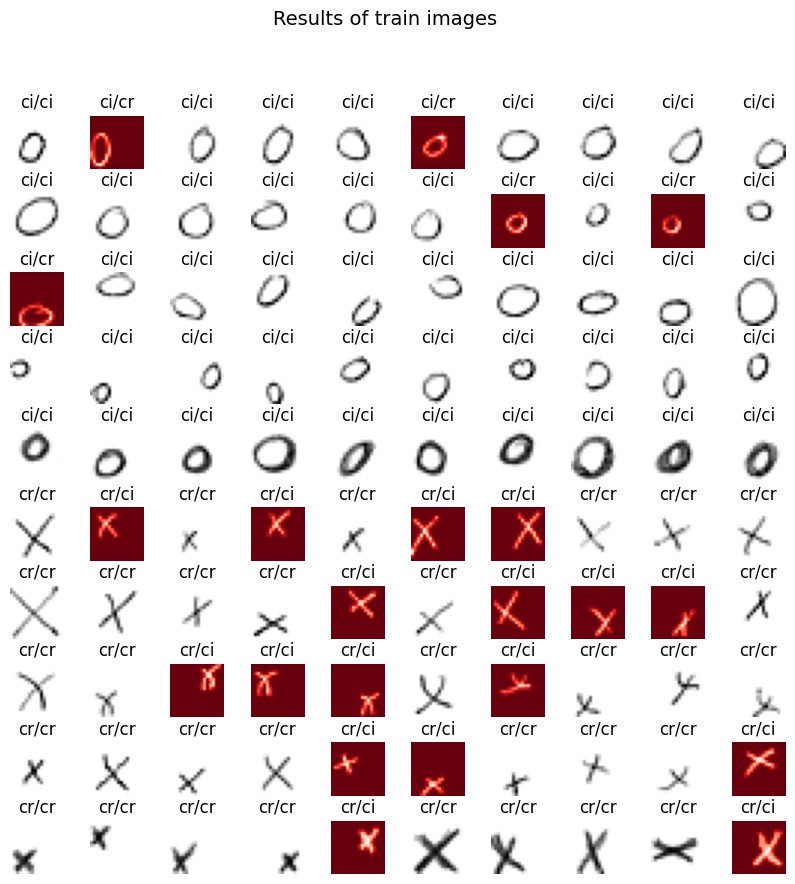

In [65]:
# show train images
fig, ax = plt.subplots(train_rows, train_cols, figsize=(train_cols, train_rows))
fig.suptitle('Results of train images', fontsize=14)
ax = ax.ravel()
for i in range(train_num):
    cmap = 'gray' if int(y_train[i]) == int(y_train_pred[i]) else 'Reds'
    ax[i].imshow(X_train[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(y_train[i])][:2]}/{labels[int(y_train_pred[i])][:2]}")
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

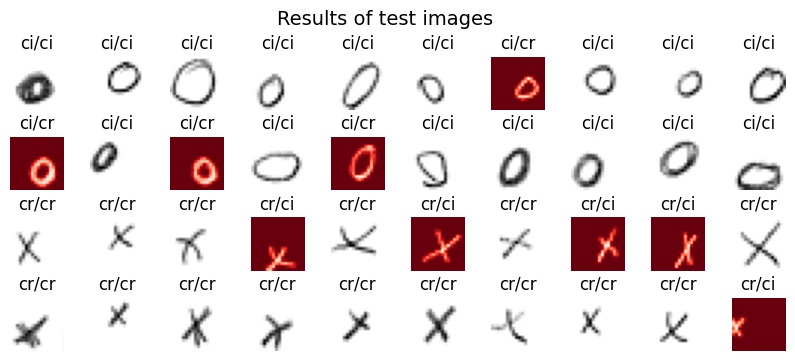

In [67]:
# show train images
fig, ax = plt.subplots(4, 10, figsize=(10, 4))
fig.suptitle('Results of test images', fontsize=14)
ax = ax.ravel()
for i in range(40):
    cmap = 'gray' if int(y_test[i]) == int(y_test_pred[i]) else 'Reds'
    ax[i].imshow(X_test[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(y_test[i])][:2]}/{labels[int(y_test_pred[i])][:2]}")
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)